# `room_acoustics`

The `room_acoustics` module contains multiple useful functions for analyzing room impulse responses (RIR). In this notebook, there are some examples of how to use most of the functionality of the module.

In [36]:
import dsptoolbox as dsp
from os.path import join
import numpy as np

## 1. Apply RIR to signal

In [37]:
speech = dsp.Signal(join('data', 'speech.flac'))
rir = dsp.Signal(join('data', 'rir.wav'), signal_type='rir')

speech_room = dsp.room_acoustics.convolve_rir_on_signal(
    speech, rir, keep_peak_level=True, keep_length=False)

# Hear the input and output
# dsp.audio_io.play(speech)
# dsp.audio_io.play(speech_room)

## 2. Model and analyze a Shoebox room
Analyzing room acoustics in the simplified model of a shoebox room gives important insights into different phenomena and allows for easy computations. The class `ShoeboxRoom` handles some of the useful algorithms to analyze a room.

Mixing time [s]: 0.0251 s

Critical distance [m]: 0.8899830761179662

Schroeders Frequency [Hz]: 128.09232339255118

Modal density @ 250 Hz [1/Hz]: 1.1378545783320972

Modes
 [[38.11111111  0.          1.          0.        ]
 [42.875       1.          0.          0.        ]
 [57.36481862  1.          1.          0.        ]
 [68.6         0.          0.          1.        ]
 [76.22222222  0.          2.          0.        ]] 



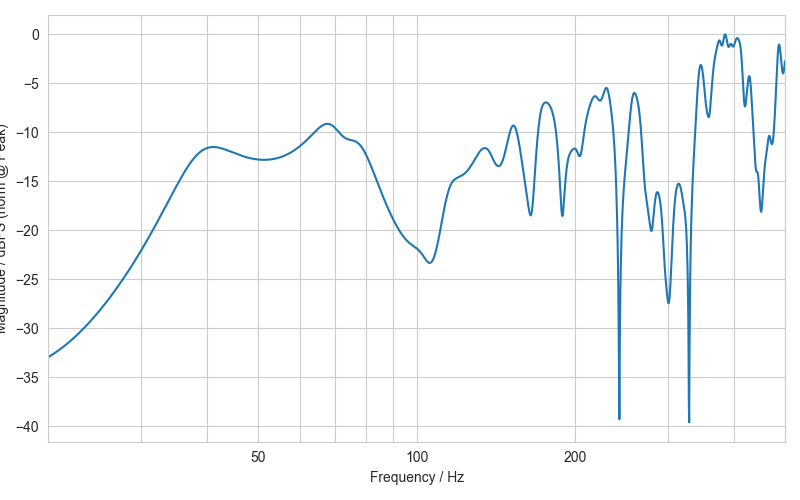

In [39]:
# Instantiate a room
room = dsp.room_acoustics.ShoeboxRoom(dimensions_m=[4, 4.5, 2.5],
                                      t60_s=None,                   # Reverberation time
                                      absorption_coefficient=0.5)   # Absorption coefficient

# Analyze mixing time in the room
print(f'''Mixing time [s]: {room.get_mixing_time(mode='perceptual'):.4f} s\n''')

# Get critical distance for an omnidirectional source
print(f'Critical distance [m]: {room.critical_distance_m}\n')

# Schroeders Frequency
print(f'Schroeders Frequency [Hz]: {room.schroeders_frequency}\n')

# Modal density for a frequency
print(f'Modal density @ 250 Hz [1/Hz]: {room.modal_density(250)}\n')

# See room modes
modes = room.get_room_modes()
print('Modes\n', modes[:5], '\n')

# Get an analytical transfer function (through modal superposition) from one
# point in the room to another
freqs = np.linspace(20, 500, 1000)
room.get_analytical_transfer_function([1, 1, 1], [2, 2, 2], freqs=freqs,
                                      generate_plot=True);

It is also possible to generate a RIR using the image-source model, as demonstrated in the next example

## 3. Generate RIR

In order to generate a RIR (using the image-source model), a shoebox room must be modeled. Its absorption characteristics can be simple or more complex as it will be shown.

NOTE: The computation of the RIR is difficult and it can take a while to complete depending on the room's absorption and size.

(<Figure size 800x500 with 1 Axes>,
 <AxesSubplot: xlabel='Frequency / Hz', ylabel='Magnitude / dB (normalized @ 1 kHz)'>)

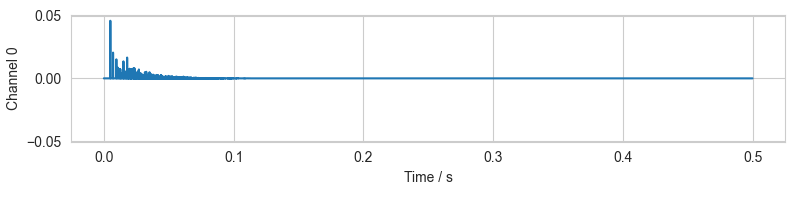

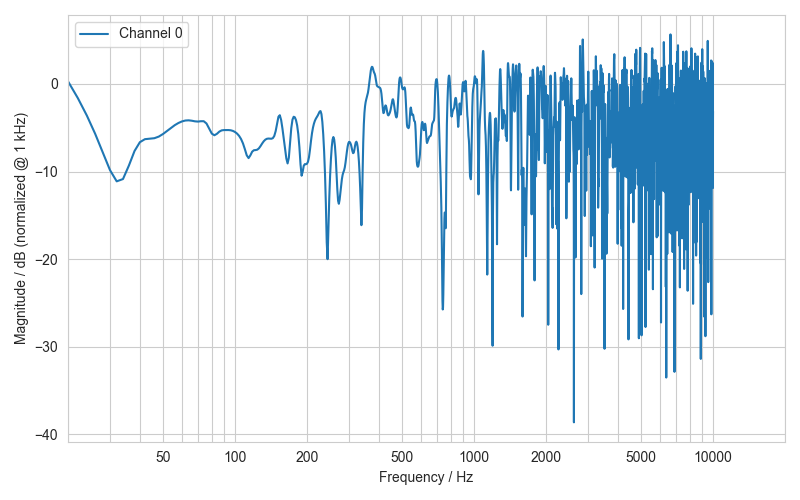

In [42]:
# Create room
room = dsp.room_acoustics.ShoeboxRoom([4, 4.5, 2.5],
                                      absorption_coefficient=0.6)

# Basic room creation
rir = dsp.room_acoustics.generate_synthetic_rir(
    room, source_position=[1, 1, 1], receiver_position=[2, 2, 2],
    sampling_rate_hz=20_000)

rir.plot_time()
rir.plot_magnitude()

In [58]:
# For a more detailed RIR, use the detailed absorption of the room
room.add_detailed_absorption({'north': [0.3, 0.4],
                              'south': [0.4, 0.6, 0.6],
                              'east': 0.5,
                              'west': 0.6,
                              'ceiling': 0.8,
                              'floor': 0.2})


rir = dsp.room_acoustics.generate_synthetic_rir(
    room, source_position=[1, 1, 1], receiver_position=[2, 2, 2],
    sampling_rate_hz=20_000,
    add_noise_reverberant_tail=True,    # Adds noise as the reverberant tail in order to simulate the diffuse field (perceptually motivated)
    use_detailed_absorption=True,       # Use the detailed absorption of the room. Computation time might increase significantly
    max_order=45                        # Maximum reflection order for the computation
)

# Print dictionary with all metadata about the room's absorption
room.detailed_absorption


RIR Generator

Band 1 of 3 is being computed...
Band 2 of 3 is being computed...
Band 3 of 3 is being computed...


{'north': array([0.3, 0.4, 0.4]),
 'south': array([0.4, 0.6, 0.6]),
 'east': array([0.5, 0.5, 0.5]),
 'west': array([0.6, 0.6, 0.6]),
 'ceiling': array([0.8, 0.8, 0.8]),
 'floor': array([0.2, 0.2, 0.2]),
 'absorption_matrix': array([[0.3, 0.4, 0.4],
        [0.4, 0.6, 0.6],
        [0.5, 0.5, 0.5],
        [0.6, 0.6, 0.6],
        [0.2, 0.2, 0.2],
        [0.8, 0.8, 0.8]]),
 'absorption_area': array([37.375, 40.375, 40.375]),
 'mean_absorption_coefficients_per_frequency': array([0.47611465, 0.51433121, 0.51433121]),
 'center_frequencies': array([125, 250, 500]),
 't60_s_per_frequency': array([0.19384615, 0.17944272, 0.17944272]),
 'index_wall_dictionary': {'north': 0,
  'south': 1,
  'east': 2,
  'west': 3,
  'floor': 4,
  'ceiling': 5},
 'README': "This dictionary contains all information about the room's\nabsorption properties. Its keys are:\n\n- absorption_matrix : array containing absorption with shape\n(wall, frequency band) = (6, number of bands). Frequencies are in increasing\no

## 4. Get room descriptors

Reverberation time [s]:  [0.2386943]  s
Bass ratio [1]:  [1.66887764]
Clarity 80 [dB]:  [25.2681502]  dB
Central time [s]:  [0.01128474]  s


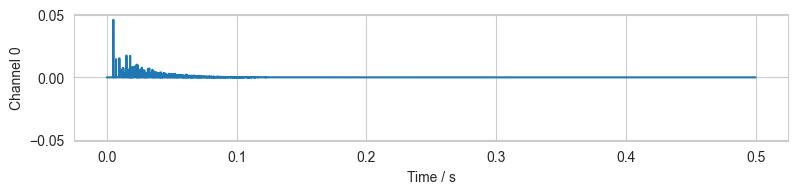

In [61]:
%matplotlib inline
rir.plot_time()

# Reverberation time
print('Reverberation time [s]: ', dsp.room_acoustics.reverb_time(rir, 'T60'), ' s')

# Other descriptors
print('Bass ratio [1]: ', dsp.room_acoustics.descriptors(rir, mode='br'))
print('Clarity 80 [dB]: ', dsp.room_acoustics.descriptors(rir, mode='c80'), ' dB')
print('Central time [s]: ', dsp.room_acoustics.descriptors(rir, mode='ts'), ' s')
